# 09-PSF_Phot

Here I benchmarked the DAOPHOT (originally called DAOPHOT II) by P. B. Stetson, which is implemented to [IRAF's psf noao.digiphot.daophot](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?psf).

In [1]:
from pathlib import Path
import numpy as np

from astropy.io import fits

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DAOGroup
from photutils.psf import FittableImageModel
from photutils.utils import random_cmap
cmap = random_cmap(random_state=12345)

from scipy.interpolate import RectBivariateSpline

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter

from astropy.visualization import ZScaleInterval, ImageNormalize, LinearStretch
from astropy.stats import sigma_clipped_stats
from astropy.nddata import CCDData, Cutout2D
from astropy.table import Table, vstack
from astropy.modeling.fitting import LevMarLSQFitter

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

plt.style.use('default')
rcParams.update({'font.size':12})

from matplotlib import pyplot as plt

def colorbaring(fig, ax, im, fmt="%d"):
    cb = fig.colorbar(im, ax=ax, orientation='horizontal', format=FormatStrFormatter(fmt))
    return cb

def znorm(image, stretch=LinearStretch(), **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs), stretch=stretch)


def zimshow(ax, image, stretch=LinearStretch(), cmap=None, **kwargs):
    return ax.imshow(image, norm=znorm(image, stretch=stretch, **kwargs), origin='lower', cmap=cmap)

PSFPATH = Path("tmp/psf_01.fits")
PHOTPSFPATH = Path("tmp/psf_01.csv")
DATAPATH = Path("tmp/SNUO_STX16803-M11-1-1-20190507-171622-V-60.0_CR.fits")
PSF_OVERSAMPLE = 4
FITTER = LevMarLSQFitter()
phot_psf = Table.read(PHOTPSFPATH)

psf_init_rawdata = fits.getdata(PSFPATH)
psf_init = FittableImageModel(data=psf_init_rawdata,
                              oversampling=PSF_OVERSAMPLE,
                              normalize=True,
                              ikwargs={"degree":[3, 3], "s":0})

fwhm = 12
psf_size = fwhm * 3 + 1
r_fit = 5 # max(2, min(fwhm, 5))

ccd = yfu.load_ccd(DATAPATH)
hdr = ccd.header
err = yfu.make_errmap(ccd=ccd, gain_epadu=hdr["GAIN"], rdnoise_electron=hdr["RDNOISE"])
data = ccd.data

ccd.uncertainty = err

INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


In [2]:
cuts = dict(cut_data=[], err=[], fit=[])


for row in phot_psf:
    pos = (row["xcentroid"], row["ycentroid"])        
#     pos_cut = cut.to_cutout_position(pos)
    result = ypu.dao_nstar(data=data, 
                           position=pos, 
                           r_fit=r_fit, 
                           psf=psf_init,
                           flux_init=row["source_sum"], 
                           sky=row["msky"], 
                           err=err, 
                           full=True)
    fit, pos_fit, fitter, astropy_weight, fcut, fcut_skysub, fcut_err = result

    scut = Cutout2D(data, position=pos, size=3 * psf_size)  # "subtraction" cut

    yy_sub, xx_sub = np.mgrid[:scut.data.shape[1], :scut.data.shape[0]]
    
    
    
    star = fit(xx_sub + scut.origin_original[0], yy_sub + scut.origin_original[1])
    cuts["cut_data"].append(scut.data)
    cuts["err"].append(fcut_err)
    cuts["fit"].append(star)

cuts_tab = Table(cuts)

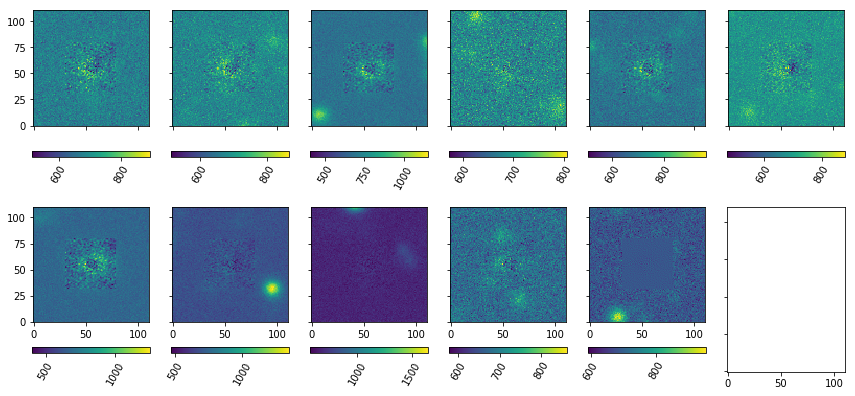

In [3]:
ncol = 6
nrow = max(len(cuts_tab) // ncol + 1, 1)
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 2.8 * nrow), sharex=True, sharey=True)

for i, row in enumerate(cuts_tab):
    # Figure plotting
    irow = i // ncol
    icol = i - irow * ncol
    ax = axs[irow, icol]
#     posstr = f"({row['xcentroid']:.1f}, {row['ycentroid']:.1f})"
    
    # For showing bright star for PSF, it's better to set high vmin, not zscale,
    # because the central structure near the star cneter is important.
    im = ax.imshow(row["cut_data"] - row["fit"], origin='lower')
    cb = colorbaring(fig, ax, im)
    plt.setp(cb.ax.get_xticklabels(),rotation=60)
    
plt.tight_layout()


In [4]:
################# FOR TEST #################
ccd = CCDData(data=ccd.data[1000:2000,1000:2000],#[2000:3000,2000:3000], ################# FOR TEST #################
              uncertainty=err[1000:2000,1000:2000],#[2000:3000,2000:3000], ################# FOR TEST #################
              header=ccd.header, unit='adu')

############################################
ccd.data = np.pad(ccd.data, pad_width=psf_size//2, mode='constant',
                  constant_values=np.nan)
ccd.uncertainty.array = np.pad(ccd.uncertainty.array, pad_width=psf_size//2, mode='constant',
                               constant_values=np.nan)
err = yfu.make_errmap(ccd=ccd, gain_epadu=hdr["GAIN"], rdnoise_electron=hdr["RDNOISE"])
data = ccd.data


avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=10, std_ddof=1)
threshold = med - 5 * std
print(avg, med, std, threshold)

finder = DAOStarFinder(fwhm=fwhm, threshold=threshold,
                       sharplo=0., sharphi=2.0,   # default values 0.2 and 1.0
                       roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                       sigma_radius=2.5,           # default values 1.5
                       ratio=1.0,                  # 1.0: circular gaussian
                       exclude_border=True)        # To exclude sources near edges

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
found = finder(data)
star_groups = ypu.group_stars(table=found,
                              crit_separation=2.8 * fwhm, 
                              xcol="xcentroid",
                              ycol="ycentroid",
                              index_only=False)

INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
682.7711791992188 681.6475830078125 26.506486892700195 549.1151485443115


/Users/ysbach/anaconda3/lib/python3.6/site-packages/ysfitsutilpy-0.0.2.dev0-py3.6.egg/ysfitsutilpy/ccdutil.py:246: RuntimeWarning: invalid value encountered in less


97 star groups out of 114 stars


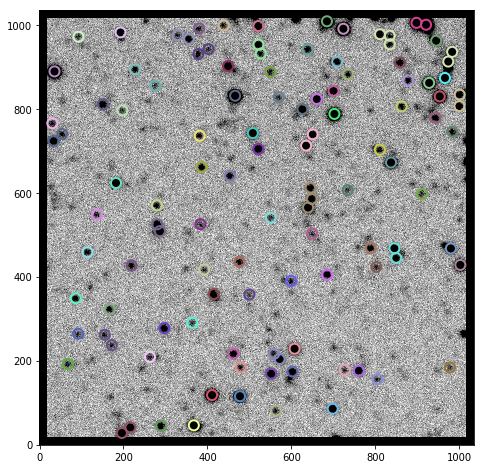

<Figure size 432x288 with 0 Axes>

In [5]:
coords_SF = (found['xcentroid'], found['ycentroid'])
ap_found = CAp(coords_SF, r=25) 

print(f"{len(star_groups.groups)} star groups out of {len(star_groups)} stars")

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False, gridspec_kw=None)
zimshow(axs, data, cmap="gray_r")

for i, group in enumerate(star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
    ap = CAp(xypos, r=fwhm)
    ap.plot(color=cmap.colors[i], lw=2)
plt.show()

plt.tight_layout()

In [6]:
r_fit = 5 # max(2, min(fwhm, 5))
fbox = 2 * r_fit + 1 # fitting box size
r_in = 4 * fwhm
r_out = 6 * fwhm

xypos = np.transpose([star_groups['x_0'], star_groups['y_0']])
ap = CAp(xypos, r=r_fit)
an = CAn(xypos, r_in=r_in, r_out=r_out)
phot = ypu.apphot_annulus(ccd, aperture=ap, annulus=an, error=err,
                          sky_keys={"mode_option":"MMM"})
phot["group_id"] = star_groups["group_id"]
phot = Table(phot)

In [7]:
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,msky,nrej,nsky,ssky,source_sum,source_sum_err,mag,merr,group_id
,pix,pix,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,int64,int64,float32,float64,float64,float64,float64,int64
1,196.15532283906907,27.69205454623709,116393.43761479223,298.36709008916563,675.494140625,30,4986,24.886099,63340.25187153096,372.06213982464084,-7.558821339052417,0.006377640184423695,1
2,216.48968263573465,41.126015192025285,87865.14160948555,260.8567354806129,676.9630126953125,128,5566,25.81425,34696.59092359536,348.02551743258834,-6.905338888409781,0.010890519627369989,1
3,289.4491495566894,44.783696511952996,71012.13949052122,235.91168616194733,678.1519165039062,336,5550,26.499228,17750.212517858454,334.04514555075883,-6.177630766783563,0.020432707956778616,2
4,367.56051239892054,45.89764638051626,149845.0080322842,337.075159431371,681.5946044921875,102,5842,27.49353,96312.69297730678,416.87599647535905,-8.013830689638931,0.004699457031842786,3
5,563.3051105435624,80.89139889991701,61924.645120489746,221.29695593293846,677.6064453125,26,8624,24.99503,8705.559355018646,313.82651399296054,-5.404113576314007,0.03913968010094179,4
6,698.3589282081895,85.37426132498825,88887.67104219139,262.29391263850425,677.2939453125,163,8750,25.142847,35693.128969326455,344.8096615695094,-6.936083427072965,0.010488638685561522,5
7,477.5538845356222,115.18385358012684,163532.08381072897,351.68691969782867,676.2950439453125,700,8343,27.009066,110415.99526778447,426.04815148135964,-8.162201852663152,0.004189392142974701,6
8,410.9698130167809,117.98986507447029,217924.9927581291,404.5719641110001,680.1154174804688,545,8494,27.94696,164508.8527793842,474.9608731325447,-8.595095058476021,0.0031346775999653697,7


In [ ]:
data_staronly = np.zeros_like(data)
xx_all, yy_all = np.mgrid[:data_staronly.shape[1], :data_staronly.shape[0]]

phot_g = phot.group_by("group_id")
for i, group in enumerate(phot_g):
    group = Table(group)
    sky = np.mean(group["msky"])  # use avg sky; see comment below.
    for row in group:
        pos_init = np.transpose([row["xcenter"], row["ycenter"]])
        result = ypu.dao_nstar(data=data, position=pos_init, r_fit=r_fit, psf=psf_init,
                               flux_init=row["source_sum"], sky=sky, err=err, full=True)
        fit, pos_fit, fitter, astropy_weight, fcut, fcut_skysub, fcut_err = result
        scut = Cutout2D(data, position=pos_fit, size=psf_size)  # "subtraction" cut
        fit.x_0, fit.y_0 = scut.to_cutout_position(pos_fit)
        
        yy_sub, xx_sub = np.mgrid[:scut.data.shape[1], :scut.data.shape[0]]
        star = fit(xx_sub, yy_sub)
        data_staronly[scut.slices_original] += star

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False, gridspec_kw=None)
zimshow(axs[0], data - data_staronly)
zimshow(axs[1], data)
# axs[1].imshow(data / (data - data_staronly), vmin=-2, vmax=+2)
axs[0].plot(phot["xcenter"], phot["ycenter"], 'ro', mfc='none')
axs[1].plot(phot["xcenter"], phot["ycenter"], 'ro', mfc='none')
plt.tight_layout()


In [ ]:
model_fitted = fit(xx_sub, yy_sub)
scut_skysub = scut.data - sky
scut_err = Cutout2D(err, position=pos_fit, size=psf_size).data
residual = scut_skysub - model_fitted

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=False, sharey=False, gridspec_kw=None)
axo = axs[0, 0]  # original
axd = axs[0, 1]  # DAOphot weight
axp = axs[0, 2]  # phot error
axf = axs[1, 0]  # fit
axr = axs[1, 1]  # residual
ax1 = axs[1, 2]  # residual / phot err

im = axo.imshow(scut_skysub, origin="lower")
cs = axo.contour(scut_skysub, colors='k', levels=np.arange(0, 1000, 200))
axo.clabel(cs, inline=1, colors='w', fmt="%.0f")
axo.set_title("Original image near the star")
colorbaring(fig, axo, im)

im = axd.imshow(1.e+4 * astropy_weight**2, origin="lower")
cs = axd.contour(1.e+4 * astropy_weight**2, colors='k', levels=np.arange(6, 13, 2))
axd.clabel(cs, inline=1, colors='w', fmt="%.0f")
axd.set_title("DAOPHOT weight * 10^4")
colorbaring(fig, axd, im)

im = axp.imshow(1.e+4 / fcut_err**2, origin="lower")
cs = axp.contour(1.e+4 / fcut_err**2, colors='k', levels=np.arange(8, 16, 2))
axp.clabel(cs, inline=1, colors='w', fmt="%.0f")
axp.set_title("10^4 / phot_err^2")
colorbaring(fig, axp, im)

im = axf.imshow(model_fitted, origin='lower')
cs = axf.contour(model_fitted, colors='k', levels=np.arange(0, 1000, 200))
axf.clabel(cs, inline=1, colors='w', fmt="%.0f")
axf.set_title("PSF fitted")
colorbaring(fig, axf, im)

im = axr.imshow(residual, origin='lower')
axr.set_title("PSF fit residual")
colorbaring(fig, axr, im)

im = ax1.imshow(residual / scut_err, origin='lower')
ax1.set_title("residual / phot_err")
colorbaring(fig, ax1, im)

plt.tight_layout()